# Foreign Exchange Return Forecasting of Neighboring Countries based on Powerful Anchor Countries
# *SIADS 696: Milestone II*

### *By Team #2*

## Overview

*Our team studied the impact on foreign exchange returns between neighboring countries and anchoring countries (neighboring countries with a larger GDP). We studied:*

`H_0` (null): Anchoring country foreign exchange rates have no impact on foreign exchange return rates of neighboring countries.

`H_1` (alternative): Anchoring country foreign exchange rates have impact on foreign exchange return rates of neighboring countries.


## Setup

```
.
├── data
│   ├── input
│   └── output
├── docs
├── logs
└── src


## Sections
- Defining Custom Functions
- Importing Data
- Applying Unsupervised Learning
- Applying Supervised Learning
    - Grangier Causality
    - Linear Regression
    - XGBoost
    - KNN
- Testing Model Performance
    - Performing Ablation
    - Performing Feature Importance
- Visualization
- Conclusion


## Setup

In [1]:
# Importing Packages
import country_converter as coco
import matplotlib.pyplot as plt
import xgboost as xgb
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
import csv
import re

# Importing partial packages
from sklearn.metrics import root_mean_squared_error, silhouette_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from utility import create_lag, load_data
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

In [2]:
# Ignoring unnecessary warnings
warnings.filterwarnings("ignore")

# Showing all rows
# pd.set_option('display.max_rows', 100)

## Defining Custom Functions

In [138]:
# Preprocessing column names to standardize
def standardize_column_names(dataframe):
    dataframe.columns = [
        str(column).lower().replace(" ", "_").replace(",", "")
        for column in dataframe.columns
    ]

    return dataframe

In [139]:
def xxxusd(code):
    x = f"{code}USD=X", f"USD{code}=X"
    return x

In [140]:
# Preprocessing functions
def clean(country):
    if pd.isna(country):
        return country
    country = str(country).strip()
    country = p.sub("", country)
    return re.sub(r",\s*The$", "", country, flags=re.I)

In [141]:
# Preprocessing functions
def short(country):
    if pd.isna(country):
        return pd.NA
    res = cc.convert(names=clean(country), to="name_short")
    if isinstance(res, (list, tuple)):
        res = res[0] if res else pd.NA
    if not res or res == "not found" or pd.isna(res):
        warnings.warn(f"Problem: {country}")
        return pd.NA
    return res

In [142]:
# Defining the Granger causality function
def granger(res, g, ml=5, a=0.05):
    x = []
    for i, j in g.items():
        for k in j:
            if i not in res.columns or k not in res.columns:
                continue
            df = pd.concat([res[k], res[i]], axis=1).dropna()
            df.columns = ["neighbor", "anchor"]
            if len(df) <= ml * 3:
                continue
            t = grangercausalitytests(df, maxlag=ml)
            pval = [t[lag][0]["ssr_ftest"][1] for lag in range(1, ml + 1)]
            min_p = float(np.min(pval))
            best_lag = int(np.argmin(pval) + 1)
            x.append(
                {
                    "anchor": i,
                    "neighbor": k,
                    "min_pval": round(min_p, 4),
                    "best_lag (days)": best_lag,
                    "significant": (min_p < a),
                }
            )
    rdf = pd.DataFrame(x)
    return rdf

In [143]:
def create_lag(neighbor, dataframe):
    # Create lag features (e.g., previous 5 days' returns)
    for i in range(1, 25):
        dataframe[f"return_lag_{i}"] = dataframe[neighbor].pct_change().shift(i)

    # Create moving average features
    dataframe["MA_30"] = dataframe[neighbor].rolling(window=30).mean().shift(1)
    dataframe["MA_60"] = dataframe[neighbor].rolling(window=60).mean().shift(1)
    dataframe["MA_90"] = dataframe[neighbor].rolling(window=90).mean().shift(1)

    # Drop initial rows with NaNs created by rolling windows
    dataframe.dropna(inplace=True)
    dataframe = dataframe.replace([np.inf, -np.inf], np.nan).fillna(0)

    return dataframe

In [144]:
# Run this for the neighbor alone: control
# Run this for the anchor + neighbor: treatment
def perform_xgb_for_anchor_neighbor(neighbor, dataframe):
    # Starting with CNY/CDF as an example
    dataframe["target"] = dataframe[neighbor].shift(-1)

    # Define features (X) and target (y)
    features = [
        col
        for col in dataframe.columns
        if col == neighbor or col.startswith("MA_") or col.startswith("return_lag_")
    ]
    X = dataframe[features]
    y = dataframe["target"]

    # Time-based train-test split
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    xgb_0 = xgb.XGBRegressor()
    parameters = {
        "nthread": [4],
        "objective": ["reg:squarederror"],
        "learning_rate": [0.08, 0.15, 0.3],
        "max_depth": [2, 4, 8],
        "min_child_weight": [4],
        "subsample": [0.2, 0.5, 0.8],
        "colsample_bytree": [0.7],
        "n_estimators": [2, 5, 10],
    }

    xgb_grid = GridSearchCV(xgb_0, parameters, cv=2, n_jobs=5, verbose=True)
    xgb_grid.fit(X_train, y_train)

    return xgb_grid.best_score_, xgb_grid.best_params_

In [145]:
# Decide best lag
def mlag(df, col, lag):
    for k in range(1,lag+1):
        df[f"{col}_lag{k}"] = df[col].shift(k)
    return df

## Importing Data

In [147]:
# Importing Real GDP Purchasing Power Parity
# Note the Ranking; 1 = big country per region
country_gdp = pd.read_csv("../data/input/real_gdp_purchasing_power_parity_0.csv")

# Displaying the first 5 rows of the dataframe
country_gdp.head()

,name,slug,value,date_of_information,ranking,region
0,China,china,"$33,598,000,000,000",2024,1,East and Southeast Asia
1,United States,united-states,"$25,676,000,000,000",2024,2,North America
2,India,india,"$14,244,000,000,000",2024,3,South Asia
3,Russia,russia,"$6,089,000,000,000",2024,4,Central Asia
4,Japan,japan,"$5,715,000,000,000",2024,5,East and Southeast Asia


In [148]:
# Importing Fred Anchors
df_fred_world_gdp = pd.read_csv("../data/input/fred_anchors_0.csv")

# Preprocessing Fred Anchors
df_fred_world_gdp["observation_date"] = pd.to_datetime(
    df_fred_world_gdp["observation_date"]
)
df_fred_world_gdp["time_period"] = df_fred_world_gdp["observation_date"].dt.year
df_fred_world_gdp = df_fred_world_gdp.drop(columns=["observation_date"]).rename(
    columns={"NYGDPMKTPCDWLD": "world_gdp"}
)

# Displaying the first 5 rows of the dataframe
df_fred_world_gdp.head()

,world_gdp,time_period
0,1.366519e+12,1960
1,1.444156e+12,1961
2,1.545552e+12,1962
3,1.671283e+12,1963
4,1.832063e+12,1964


In [149]:
# Importing GDP
df_imf_gdp = pd.read_csv(
    "../data/input/imf_gdp_0.csv",
    on_bad_lines="skip",
    sep=",",
    quoting=csv.QUOTE_ALL,
    skipinitialspace=True,
    usecols=[
        "COUNTRY",
        "TIME_PERIOD",
        "TYPE_OF_TRANSFORMATION",
        "FREQUENCY",
        "OBS_VALUE",
        "INDICATOR",
    ],
    engine="python",
)

# Preprocessing GDP
df_imf_gdp = (
    standardize_column_names(df_imf_gdp)
    .query(
        "indicator == 'US Dollar per domestic currency' "
        "and type_of_transformation == 'End-of-period (EoP)' "
        "and frequency == 'Annual'"
    )
    .dropna(subset=["obs_value"])
    .rename(columns={"time_period": "year"})
    .assign(year=lambda d: d["year"].str[:4])
    .sort_values(["country", "year"])
    .drop(columns=["indicator", "type_of_transformation", "frequency"])
    .reset_index(drop=True)
).assign(year=lambda d: pd.to_datetime(d["year"], errors="coerce").dt.year)

# Displaying the first 5 rows of the dataframe
df_imf_gdp.head()

,country,year,obs_value
0,"Afghanistan, Islamic Republic of",1955,0.059081
1,"Afghanistan, Islamic Republic of",1956,0.059081
2,"Afghanistan, Islamic Republic of",1957,0.059081
3,"Afghanistan, Islamic Republic of",1958,0.059081
4,"Afghanistan, Islamic Republic of",1959,0.059081


In [150]:
# Importing Exchange Rates
df_imf_trade = pd.read_csv(
    "../data/input/imf_trade_0.csv",
    usecols=[
        "COUNTRY",
        "COUNTERPART_COUNTRY",
        "TIME_PERIOD",
        "OBS_VALUE",
        "TRADE_FLOW",
        "SCALE",
        "UNIT",
    ],
)

# Manually excluding countries that are either trade in pegged currencies or don't have a true boundary from another
ls_0 = [
    "World",
    "Advanced Economies",
    "Latin America and the Caribbean (LAC)",
    "Hong Kong Special Administrative Region, People's Republic of China",
    "Emerging and Developing Europe",
    "Middle East and Central Asia",
    "Emerging Market and Developing Economies",
    "Euro Area (EA)",
    "Emerging and Developing Asia",
]

# Excluding the "Exclusion List"
df_imf_trade = df_imf_trade[
    (~df_imf_trade["COUNTRY"].isin(ls_0))
    & (~df_imf_trade["COUNTERPART_COUNTRY"].isin(ls_0))
]

# Viewing first five rows
df_imf_trade = standardize_column_names(df_imf_trade).sort_values(
    by=["obs_value"], ascending=False
)

# Displaying the first 5 rows of the dataframe
df_imf_trade.head()

,country,counterpart_country,time_period,obs_value,scale,trade_flow,unit
400545,"China, People's Republic of",United States,2021-Q4,1.651331e+11,Millions,Exports of goods,US dollar
400544,"China, People's Republic of",United States,2021-Q3,1.590074e+11,Millions,Exports of goods,US dollar
400548,"China, People's Republic of",United States,2022-Q3,1.558462e+11,Millions,Exports of goods,US dollar
400547,"China, People's Republic of",United States,2022-Q2,1.542070e+11,Millions,Exports of goods,US dollar
400557,"China, People's Republic of",United States,2024-Q4,1.430223e+11,Millions,Exports of goods,US dollar


In [151]:
# Preprocessing Exchange Rates
cc = coco.CountryConverter()
p = re.compile(
    r",\s*(?:Kingdom of the Netherlands|United Kingdom-British Overseas Territory|Republic of the|Union of the|State of the)$",
    re.I,
)

# Defining countries with pegged currencies
pegged = [
    "Aruba",
    "The Bahamas",
    "Bahrain",
    "Barbados",
    "Belize",
    "Bermuda",
    "Cayman Islands",
    "Cuba",
    "Djibouti",
    "Antigua and Barbuda",
    "Dominica",
    "Grenada",
    "Saint Kitts and Nevis",
    "Saint Lucia",
    "Saint Vincent and the Grenadines",
    "El Salvador",
    "Eritrea",
    "Hong Kong",
    "Jordan",
    "Kuwait",
    "Lebanon",
    "Curaçao",
    "Sint Maarten",
    "Oman",
    "Panama",
    "Qatar",
    "Saudi Arabia",
    "United Arab Emirates",
    "Venezuela",
]

pegged = {short(x) for x in pegged}
pegged.discard(pd.NA)

In [152]:
# Defining countries in the European Union that use the Euro (EUR) and British Pound (GBP)
EUR = [
    "Austria",
    "Belgium",
    "Cyprus",
    "Estonia",
    "Finland",
    "France",
    "Germany",
    "Greece",
    "Ireland",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Malta",
    "Netherlands",
    "Portugal",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Andorra",
    "Monaco",
    "San Marino",
    "Vatican City",
    "Saint Barthélemy",
    "Saint Pierre and Miquelon",
    "Kosovo",
    "Montenegro",
    "Bosnia and Herzegovina",
    "Bulgaria",
    "Cape Verde",
    "Cameroon",
    "Central African Republic",
    "Chad",
    "Republic of the Congo",
    "Equatorial Guinea",
    "Gabon",
    "Benin",
    "Burkina Faso",
    "Côte d'Ivoire",
    "Guinea-Bissau",
    "Mali",
    "Niger",
    "Senegal",
    "Togo",
    "French Polynesia",
    "New Caledonia",
    "Wallis and Futuna",
    "Comoros",
    "Croatia",
    "Morocco",
    "São Tomé and Príncipe",
    "Denmark",
    "North Macedonia",
]

# Defining countries that use the British Pound (GBP)
GBP = [
    "Guernsey",
    "Jersey",
    "Isle of Man",
    "Gibraltar",
    "Falkland Islands",
    "Saint Helena",
]

# Defining other countries with pegged currencies or no true boundary
other = [
    "Bhutan",
    "Nepal",
    "North Korea",
    "Afghanistan",
    "Turkmenistan",
    "South Sudan",
    "Guam",
    "Macau",
    "Tuvalu",
    "Kiribati",
    "Palau",
    "Greenland",
    "Maldives",
    "Iraq",
    "Solomon Islands",
    "Brunei Darussalam",
    "Bangladesh",
    "Myanmar",
    "Marshall Islands",
    "Iran",
    "Yemen",
    "Libya",
    "Somalia",
    "Liberia",
    "Sudan",
    "Sierra Leone",
    "Mongolia",
    "Angola",
    "Kyrgyz Republic",
    "Tajikistan",
]

# Cleaning country names
EUR = {short(x) for x in EUR if pd.notna(short(x))}
GBP = {short(x) for x in GBP if pd.notna(short(x))}
other = {short(x) for x in other if pd.notna(short(x))}

In [153]:
# Importing cleaned data
# TODO - where is this coming from?
# I.e. what code created these files?
df_trade = pd.read_parquet("../data/input/trade_0.parquet")
df_gdp = pd.read_parquet("../data/input/gdp_0.parquet")

## Applying Unsupervised Learning

In [154]:
# Converting country names to short format
cc = coco.CountryConverter()
p = re.compile(
    r",\s*(?:Kingdom of the Netherlands|United Kingdom-British Overseas Territory|Republic of the|Union of the|State of the)$",
    re.I,
)

In [155]:
# Anchors selection
df_gdp = df_gdp[~(df_gdp["COUNTRY"] == "United States")]
df_gdp.head()
Anchor = {
    "EUR": EUR,
    "CNY": {"China"},
    "JPY": {"Japan"},
}

# No USD due to many relationship ties with multiple currency.
# Time Period
period = 10

# N Neighbor
n = 10

# Minimum Percentage Volume
v = 0.05

# Exports of goods
# Neighbor mapping
neighbor = {x: i for i, y in Anchor.items() for x in y}
ex = EUR | GBP | other | {"China", "Japan", "United States"}
df_trade = df_trade.dropna(
    subset=["COUNTRY", "COUNTERPART_COUNTRY", "TIME_PERIOD", "OBS_VALUE"]
).copy()

# Keep data period
df_trade = df_trade[df_trade["TIME_PERIOD"].astype(str).str.match(r"^\d{4}")]
df_trade["year"] = df_trade["TIME_PERIOD"].astype(str).str[:4].astype(int)
max_year = int(df_trade["year"].max())
df_trade = df_trade[df_trade["year"].between(max_year - period + 1, max_year)]

# Filter and map potential neighbors
df_export = df_trade[~df_trade["COUNTRY"].isin(ex)].copy()
df_export["anchor"] = df_export["COUNTERPART_COUNTRY"].map(neighbor)

# Total exports per country
etot = (
    df_export.groupby("COUNTRY", as_index=False)["OBS_VALUE"]
    .sum()
    .rename(columns={"OBS_VALUE": "export_total"})
)

# Exports to each anchor
eanch = (
    df_export.dropna(subset=["anchor"])
    .groupby(["COUNTRY", "anchor"], as_index=False)["OBS_VALUE"]
    .sum()
    .rename(columns={"OBS_VALUE": "export_to_anchor"})
)

# Export shares
esh = eanch.merge(etot, on="COUNTRY", how="left").assign(
    export_share=lambda d: d["export_to_anchor"] / d["export_total"]
)

# Best export anchor per country
bexp = esh.sort_values(
    ["COUNTRY", "export_share", "export_to_anchor"], ascending=[True, False, False]
).drop_duplicates("COUNTRY")
bexp = bexp[bexp["export_share"] >= v]

# Swap role
df_import = df_trade.rename(
    columns={"COUNTRY": "COUNTERPART_COUNTRY_orig", "COUNTERPART_COUNTRY": "COUNTRY"}
).rename(columns={"COUNTERPART_COUNTRY_orig": "COUNTERPART_COUNTRY"})

# Potential neighbors
df_import = df_import[~df_import["COUNTRY"].isin(ex)].copy()
df_import["anchor"] = df_import["COUNTERPART_COUNTRY"].map(neighbor)

# Total imports per country
import_totals = (
    df_import.groupby("COUNTRY", as_index=False)["OBS_VALUE"]
    .sum()
    .rename(columns={"OBS_VALUE": "import_total"})
)

# Imports from each anchor
ianch = (
    df_import.dropna(subset=["anchor"])
    .groupby(["COUNTRY", "anchor"], as_index=False)["OBS_VALUE"]
    .sum()
    .rename(columns={"OBS_VALUE": "import_from_anchor"})
)

# Import shares
ish = ianch.merge(import_totals, on="COUNTRY", how="left").assign(
    import_share=lambda d: d["import_from_anchor"] / d["import_total"]
)

# Best import anchor per country
bimp = ish.sort_values(
    ["COUNTRY", "import_share", "import_from_anchor"], ascending=[True, False, False]
).drop_duplicates("COUNTRY")
bimp = bimp[bimp["import_share"] >= v]

In [156]:
# Combine table
comb = esh.merge(ish, on=["COUNTRY", "anchor"], how="outer", suffixes=("_exp", "_imp"))

# Handle missing value
f = [
    "export_to_anchor",
    "export_total",
    "export_share",
    "import_from_anchor",
    "import_total",
    "import_share",
]
for c in f:
    if c not in comb.columns:
        comb[c] = 0.0
comb[f] = comb[f].fillna(0.0)

# Combined metrics
comb = comb.assign(
    total_trade_with_anchor=lambda d: d["export_to_anchor"] + d["import_from_anchor"],
    total_trade_volume=lambda d: d["export_total"] + d["import_total"],
)
comb["combined_exposure"] = 0.0
nz = comb["total_trade_volume"] > 0
comb.loc[nz, "combined_exposure"] = (
    comb.loc[nz, "total_trade_with_anchor"] / comb.loc[nz, "total_trade_volume"]
)
comb_f = comb.loc[comb["combined_exposure"] >= v].copy()

# Rank neighbors per anchor
comb_f = comb_f.sort_values(
    by=[
        "anchor",
        "combined_exposure",
        "total_trade_with_anchor",
        "export_share",
        "import_share",
        "COUNTRY",
    ],
    ascending=[True, False, False, False, False, True],
)

# Rank within each anchor and take top n
comb_f["rank_within_anchor"] = comb_f.groupby("anchor")["combined_exposure"].rank(
    method="first", ascending=False
)
comb_top = comb_f.loc[comb_f["rank_within_anchor"] <= n].copy()

# Final neighbor
neighbors_dict = comb_top.groupby("anchor")["COUNTRY"].apply(list).to_dict()

# Summary results
summary = (
    comb_top[
        [
            "anchor",
            "COUNTRY",
            "combined_exposure",
            "export_share",
            "import_share",
            "export_to_anchor",
            "import_from_anchor",
            "export_total",
            "import_total",
            "total_trade_with_anchor",
            "total_trade_volume",
            "rank_within_anchor",
        ]
    ]
    .sort_values(["anchor", "rank_within_anchor"])
    .reset_index(drop=True)
)

res = summary.copy()
for col in ["combined_exposure", "export_share", "import_share"]:
    res[col] = (res[col] * 100).round(2)

res_sorted = res.sort_values(["anchor", "rank_within_anchor"])
anchor_neighbor = res_sorted.groupby("anchor")["COUNTRY"].apply(list).to_dict()

for a, c in [("CNY", "Australia"), ("JPY", "Philippines"), ("JPY", "Vietnam")]:
    if a in anchor_neighbor and c in anchor_neighbor[a]:
        anchor_neighbor[a].remove(c)

anchor_neighbor

{'CNY': ['DR Congo',
  'Laos',
  'Tanzania',
  'Chile',
  'Guinea',
  'Pakistan',
  'Philippines',
  'Vietnam',
  'Mauritania'],
 'EUR': ['Albania',
  'Czechia',
  'Tunisia',
  'Romania',
  'Hungary',
  'Poland',
  'Serbia',
  'Sweden',
  'Iceland',
  'Algeria'],
 'JPY': ['Papua New Guinea',
  'Taiwan',
  'Thailand',
  'Australia',
  'Indonesia',
  'South Korea',
  'Malaysia',
  'New Zealand']}

*Performing Principle Component Analyis (PCA) to reduce the dimensionality of our training data.*

In [157]:
# We identify the hour anchor: Anchor = {"EUR": EUR, "CNY": {"China"}, "JPY": {"Japan"}}

# Going to start by pulling Anchor Countries
# Codes are obtain from yahoo finance symbol
# https://finance.yahoo.com/markets/currencies/

fx_list = {
    # Anchor currencies
    "CNY": "CNY=X",  # China
    "EUR": "EUR=X",  # Euro
    "JPY": "JPY=X",  # Japan
    # Neutral currencies
    "CAD": "CAD=X",  # Canada
    "BRL": "BRL=X",  # Brazil
    "MXN": "MXN=X",  # Mexico
    "COP": "COP=X",  # Colombia
    "PEN": "PEN=X",  # Peru
    "NOK": "NOK=X",  # Norway
    "ZAR": "ZAR=X",  # South Africa
    "INR": "INR=X",  # India
    "TRY": "TRY=X",  # Turkey
    "EGP": "EGP=X",  # Egypt
    "RUB": "RUB=X",  # Russia
    "ILS": "ILS=X",  # Israel
    # CNY group
    "CDF": "CDF=X",  # DR Congo
    "LAK": "LAK=X",  # Laos
    "TZS": "TZS=X",  # Tanzania
    "CLP": "CLP=X",  # Chile
    "GNF": "GNF=X",  # Guinea
    "PKR": "PKR=X",  # Pakistan
    "PHP": "PHP=X",  # Philippines
    "VND": "VND=X",  # Vietnam
    "MRU": "MRU=X",  # Mauritania
    # EUR group
    "ALL": "ALL=X",  # Albania
    "CZK": "CZK=X",  # Czechia
    "TND": "TND=X",  # Tunisia
    "RON": "RON=X",  # Romania
    "HUF": "HUF=X",  # Hungary
    "PLN": "PLN=X",  # Poland
    "RSD": "RSD=X",  # Serbia
    "SEK": "SEK=X",  # Sweden
    "ISK": "ISK=X",  # Iceland
    "DZD": "DZD=X",  # Algeria
    # JPY group
    "PGK": "PGK=X",  # Papua New Guinea
    "TWD": "TWD=X",  # Taiwan
    "THB": "THB=X",  # Thailand
    "AUD": "AUD=X",  # Australia
    "IDR": "IDR=X",  # Indonesia
    "KRW": "KRW=X",  # South Korea
    "MYR": "MYR=X",  # Malaysia
    "NZD": "NZD=X",  # New Zealand
}

# Period is the timeframe we want, we conclude for the time being, it will be 10 years
PERIOD = "10y"

# We conclude we will be looking at exchanges on a daily basis.
INTERVAL = "1d"
FFill_Limit = 3
N_PCS_To_Cluster = 3
N_Cluster = 3

# Creating a list of tickers from the fx_list dictionary
tickers = list(fx_list.values())

# Creating a DataFrame by downloading historical FX data using yfinance
yfinance_fx_raw = yf.download(
    tickers, period=PERIOD, interval=INTERVAL, auto_adjust=None, progress=False
)

In [158]:
# Remove problem currency
x = yfinance_fx_raw["Close"]
c = x.notna().sum().sort_values()
c

Ticker
MRU=X    1813
TND=X    2602
CDF=X    2603
CNY=X    2603
ILS=X    2603
ALL=X    2604
PHP=X    2604
PKR=X    2604
RSD=X    2604
KRW=X    2604
JPY=X    2604
INR=X    2604
IDR=X    2604
SEK=X    2604
THB=X    2604
EUR=X    2604
EGP=X    2604
DZD=X    2604
CLP=X    2604
TWD=X    2604
BRL=X    2604
TZS=X    2604
PEN=X    2604
PGK=X    2604
RUB=X    2605
TRY=X    2605
RON=X    2605
PLN=X    2605
ZAR=X    2605
NOK=X    2605
MYR=X    2605
HUF=X    2605
CZK=X    2605
CAD=X    2605
AUD=X    2605
NZD=X    2605
VND=X    2606
ISK=X    2606
GNF=X    2606
LAK=X    2606
MXN=X    2607
COP=X    2607
dtype: int64

In [159]:
# We remove currencies that have less than 2000 data points
want = list(fx_list.keys())
t = []
invert = {}

# Loop through each currency in the want list and get their corresponding ticker symbols
for c in want:
    t1, t2 = xxxusd(c)
    t.extend([t1, t2])

# Remove duplicates while preserving order
t = list(dict.fromkeys(t))

# Creating a DataFrame by downloading historical FX data using yfinance
raw = yf.download(
    t, period=PERIOD, interval=INTERVAL, auto_adjust=None, progress=False
)["Close"]

# Creating a DataFrame to hold exchange rate levels and whether they need to be inverted
level = {}
for c in want:
    t1, t2 = xxxusd(c)
    if t1 in raw.columns and raw[t1].notna().sum() > 0:
        level[c] = raw[t1]
        invert[c] = False
    elif t2 in raw.columns and raw[t2].notna().sum() > 0:
        level[c] = 1.0 / raw[t2]
        invert[c] = True

# Creating a DataFrame from the level dictionary and sorting by index
level = pd.DataFrame(level).sort_index()

# Calculating log returns and handling missing values
lreturn = np.log(level / level.shift(1))
lreturn = lreturn.ffill(limit=3).dropna(how="any")

In [160]:
# Standardizing the log returns
scaler = StandardScaler()
X = pd.DataFrame(
    scaler.fit_transform(lreturn),
    index=lreturn.index,
    columns=lreturn.columns,
)

# PCA and KMeans Clustering
pca = PCA(n_components=2)
Z = pca.fit_transform(X.T)

# Creating a DataFrame for PCA results
pca_df = pd.DataFrame(Z, index=X.columns, columns=["PC1", "PC2"])

# KMeans Clustering
k = 3
km = KMeans(n_clusters=k, random_state=42)
pca_df["cluster"] = km.fit_predict(pca_df[["PC1", "PC2"]].to_numpy())

In [161]:
# Addidtional pull for explained_variance_ratio_
evr = pca.explained_variance_ratio_
print("Explained variance ratio: ", evr, " | Cumalative: ", evr.cumsum())

Explained variance ratio:  [0.13328402 0.05704188]  | Cumalative:  [0.13328402 0.1903259 ]


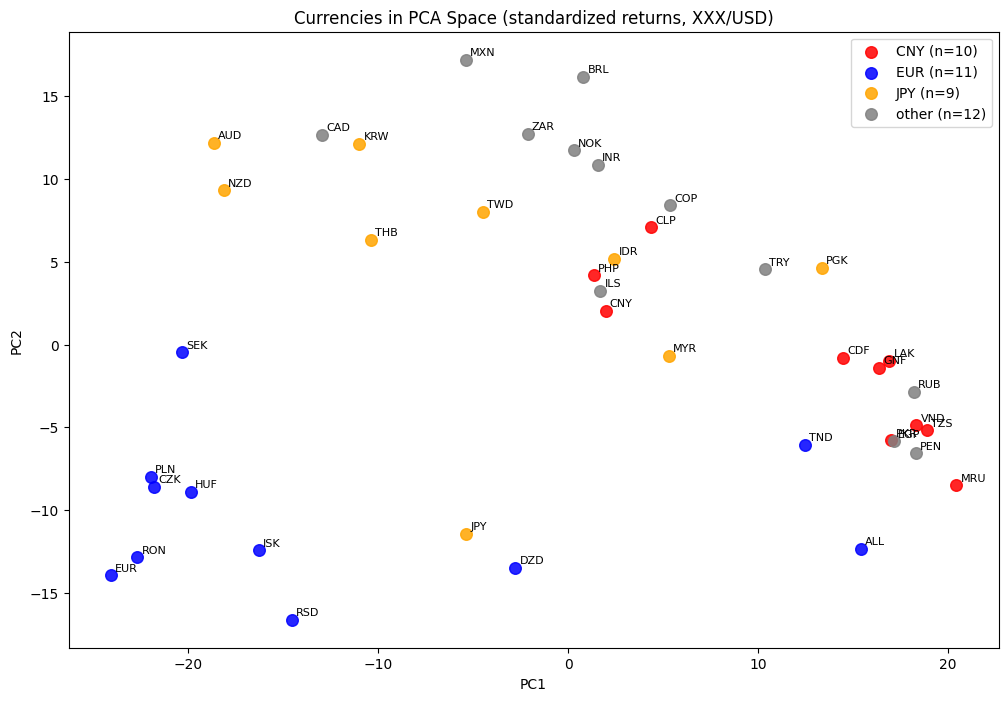

In [162]:
# Grouping currencies based on economic ties
g = {
    "CNY": ["CDF", "LAK", "TZS", "CLP", "GNF", "PKR", "PHP", "VND", "MRU"],
    "EUR": ["ALL", "CZK", "TND", "RON", "HUF", "PLN", "RSD", "SEK", "ISK", "DZD"],
    "JPY": ["PGK", "TWD", "THB", "AUD", "IDR", "KRW", "MYR", "NZD"],
}


# Function to assign group based on currency code
def assign(cc):
    for i, j in g.items():
        if cc == i or cc in j:
            return i
    return "other"


# Assigning group to each currency in the PCA DataFrame
pca_df["group"] = pca_df.index.map(assign)

# Visualization of PCA Results
col = {"CNY": "red", "EUR": "blue", "INR": "green", "JPY": "orange", "other": "gray"}
plt.figure(figsize=(12, 8))
for grp, sub in pca_df.groupby("group"):
    plt.scatter(
        sub["PC1"],
        sub["PC2"],
        c=col.get(grp, "black"),
        s=70,
        alpha=0.85,
        label=f"{grp} (n={len(sub)})",
    )
    for i, j in sub.iterrows():
        plt.annotate(
            i,
            (j["PC1"], j["PC2"]),
            xytext=(3, 3),
            textcoords="offset points",
            fontsize=8,
        )

plt.title("Currencies in PCA Space (standardized returns, XXX/USD)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [163]:
# Calculating Silhouette Score
score = silhouette_score(pca_df[["PC1", "PC2"]], pca_df["cluster"])

# Saving the log returns DataFrame to a Parquet file
lreturn.to_parquet("fx_log_return.parquet", index=False)

## Applying Supervised Learning

#### Grangier Causality

*Applying Grangier causality test to determine if a causal realtionship is found in our anchor and neighboring currency returns*

In [164]:
# Use this if the above didn't work
# This is a stashed checkpoint file
lreturn = pd.read_parquet("../data/input/fx_log_return.parquet")

# Grouping currencies based on economic ties
g = {
    "CNY": ["CDF", "LAK", "TZS", "CLP", "GNF", "PKR", "PHP", "VND", "MRU"],
    "EUR": ["ALL", "CZK", "TND", "RON", "HUF", "PLN", "RSD", "SEK", "ISK", "DZD"],
    "JPY": ["PGK", "TWD", "THB", "AUD", "IDR", "KRW", "MYR", "NZD"],
}

rdf = granger(lreturn, g, 10, 0.05)
rdf = rdf.sort_values(["anchor", "min_pval"]).reset_index(drop=True)
an = rdf[rdf["significant"] == True].sort_values(["anchor", "min_pval"])
ng = an.groupby("anchor")["neighbor"].apply(list).to_dict()
ng


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2637  , p=0.0124  , df_denom=1799, df_num=1
ssr based chi2 test:   chi2=6.2741  , p=0.0123  , df=1
likelihood ratio test: chi2=6.2632  , p=0.0123  , df=1
parameter F test:         F=6.2637  , p=0.0124  , df_denom=1799, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1649  , p=0.0425  , df_denom=1796, df_num=2
ssr based chi2 test:   chi2=6.3474  , p=0.0418  , df=2
likelihood ratio test: chi2=6.3362  , p=0.0421  , df=2
parameter F test:         F=3.1649  , p=0.0425  , df_denom=1796, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8108  , p=0.1431  , df_denom=1793, df_num=3
ssr based chi2 test:   chi2=5.4537  , p=0.1414  , df=3
likelihood ratio test: chi2=5.4455  , p=0.1419  , df=3
parameter F test:         F=1.8108  , p=0.1431  , df_denom=1793, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4194  , p=0.

{'CNY': ['VND', 'MRU', 'CDF', 'PKR'],
 'EUR': ['ALL', 'CZK', 'TND', 'RON', 'RSD', 'DZD', 'HUF', 'SEK', 'ISK', 'PLN'],
 'JPY': ['MYR', 'TWD', 'THB', 'IDR', 'AUD']}

#### K Nearest Neighbors (KNN)

In [165]:
# Filter pairs
pa = [(i, j) for i, nl in ng.items() for j in nl]

# Preparing data for modeling
res = {}

# Loop through each anchor-neighbor pair to create lagged features and target variable
for i, j in pa:
    lag = int(rdf[(rdf.anchor == i) & (rdf.neighbor == j)]["best_lag (days)"].values[0])
    f = lreturn[[i, j]].copy()
    f = mlag(f, j, 3)    
    f = mlag(f, i, lag) 
    f["target"] = f[j].shift(-1)
    f = f.dropna()
    res[(i, j)] = f

# KNN
# All pair check:
# This includes all anchor and neighbors for knn
resknn = []

# Loop through each anchor-neighbor pair to train and evaluate KNN model
for (i, j), df_0 in res.items():
    features = [col for col in df_0.columns if col not in ['target']]
    X = df_0[features]
    y = df_0['target']
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = KNeighborsRegressor(n_neighbors=5, weights='distance')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = root_mean_squared_error(y_test, y_pred)
    resknn.append({"anchor": i,"neighbor": j,"rmse": rmse})

# Creating a DataFrame from the KNN results and sorting by RMSE
knn = pd.DataFrame(resknn).sort_values("rmse").reset_index(drop=True)
knn

,anchor,neighbor,rmse
0,CNY,VND,0.002311
1,EUR,DZD,0.002841
2,JPY,MYR,0.004397
3,CNY,PKR,0.004976
4,JPY,THB,0.005402
5,EUR,RON,0.005459
6,EUR,ISK,0.005606
7,JPY,TWD,0.005921
8,EUR,CZK,0.006112
9,EUR,RSD,0.006405


#### Linear Regression

*Utilizing a linear family model*

In [166]:
# Importing data
neighbor_groups, df_anchor_neighor, df_log_return_pca = load_data()

# Compiling scores
final = []

# Running LR for each anchor neighbor pair
for option in ["Training_with_Anchor", "Training_without_Anchor"]:

    for i, j in zip(df_anchor_neighor["anchor"], df_anchor_neighor["neighbor"]):

        # Initializing dictionary to hold scores
        scores = {}

        # Preparing data for train test split
        df_1 = df_log_return_pca[[i, j]]
        df_1 = df_1.drop(columns=[i])
        df_1 = create_lag(j, df_1)
        print(df_1.columns)

        # Time-based train-test split
        df_1["target"] = df_1[j].shift(-1)
        df_1.dropna(inplace=True)

        # Define features (X) and target (y)
        if option == "Training_without_Anchor":
            features = [col for col in df_1.columns]
            i = None
        else:
            features = [
                col
                for col in df_1.columns
                if col == j or col.startswith("MA_") or col.startswith("return_lag_")
            ]

        X = df_1[features]
        y = df_1["target"]

        # Splitting data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        clf_lr = LinearRegression().fit(X, y)
        y_preds = clf_lr.predict(X_test)

        # Assigning scores
        scores["anchor"] = i
        scores["neighbor"] = j
        scores["option"] = option
        # scores['rmse'] = root_mean_squared_error(y_test, y_preds)
        scores["rmse"] = np.mean(
            np.sqrt(
                np.abs(
                    cross_val_score(
                        clf_lr, X, y, scoring="neg_mean_squared_error", cv=5, n_jobs=-1
                    )
                )
            )
        )
        scores["model"] = "Linear Regression"
        scores["params"] = None

        # print(scores)
        final.append(scores)

df_final = pd.DataFrame(final)
df_final_summary_mean = df_final.groupby("option")["rmse"].mean()
df_final_summary_std = df_final.groupby("option")["rmse"].std()
print(df_final)
print(df_final_summary_mean)
print(df_final_summary_std)

print(
    rf"Difference without anchor: {df_final_summary_mean[0] - df_final_summary_mean[1]}"
)

Index(['ALL', 'return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_4',
       'return_lag_5', 'return_lag_6', 'return_lag_7', 'return_lag_8',
       'return_lag_9', 'return_lag_10', 'return_lag_11', 'return_lag_12',
       'return_lag_13', 'return_lag_14', 'return_lag_15', 'return_lag_16',
       'return_lag_17', 'return_lag_18', 'return_lag_19', 'return_lag_20',
       'return_lag_21', 'return_lag_22', 'return_lag_23', 'return_lag_24',
       'MA_30', 'MA_60', 'MA_90'],
      dtype='object')
Index(['CZK', 'return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_4',
       'return_lag_5', 'return_lag_6', 'return_lag_7', 'return_lag_8',
       'return_lag_9', 'return_lag_10', 'return_lag_11', 'return_lag_12',
       'return_lag_13', 'return_lag_14', 'return_lag_15', 'return_lag_16',
       'return_lag_17', 'return_lag_18', 'return_lag_19', 'return_lag_20',
       'return_lag_21', 'return_lag_22', 'return_lag_23', 'return_lag_24',
       'MA_30', 'MA_60', 'MA_90'],
      dtype=

KeyboardInterrupt: 

#### Extreme Gradient Boosted Regression (XGBoost)

*Utlizing a tree family model*

In [ ]:
# Importing data
neighbor_groups, df_anchor_neighor, df_log_return_pca = load_data()

# Compiling scores
final = []

# Running LR for each anchor neighbor pair
for option in ["Training_with_Anchor", "Training_without_Anchor"]:

    for i, j in zip(df_anchor_neighor["anchor"], df_anchor_neighor["neighbor"]):
    
        # Initializing dictionary to hold scores
        scores = {}

        # Preparing data for train test split
        df_1 = df_log_return_pca[[i, j]]
        df_1 = df_1.drop(columns=[i])
        df_1 = create_lag(j, df_1)
        
        # Time-based train-test split
        df_1["target"] = df_1[j].shift(-1)
        df_1.dropna(inplace=True)

        # Define features (X) and target (y)
        if option == "Training_without_Anchor":
            features = [col for col in df_1.columns]
            i = None
        else:
            features = [col for col in df_1.columns if col == j or col.startswith("MA_") or col.startswith("return_lag_")]
            
        X = df_1[features]
        y = df_1["target"]

        # Preparing data for train test split
        df_1 = df_log_return_pca[[i, j]]
        df_1.dropna(inplace=True)
        df_1 = create_lag(j, df_1).drop(columns=[i])
        score, params, y_preds = perform_xgb_for_anchor_neighbor(j, df_1)

        # Assigning scores
        scores['anchor'] = i
        scores['neighbor'] = j
        scores['option'] = option
        scores['rmse'] = np.mean(np.sqrt(np.abs(cross_val_score(xgb.XGBRegressor(**params), X, y, scoring = 'neg_mean_squared_error', cv = 5, n_jobs = -1))))
        scores['model'] = 'XGBoost'   
        scores['params'] = None        
        
        # print(scores)
        final.append(scores)

# Organizing final results
df_final = pd.DataFrame(final)
df_final_summary_mean = df_final.groupby('option')['rmse'].mean()
df_final_summary_std = df_final.groupby('option')['rmse'].std()

# Printing final results
print(df_final)
print(df_final_summary_mean)
print(df_final_summary_std)

# Printing delta between with and without training anchor
print(rf"Difference without anchor: {df_final_summary_mean[0] - df_final_summary_mean[1]}") 

Fitting 2 folds for each of 81 candidates, totalling 162 fits


KeyboardInterrupt: 

## Testing Model Performance

#### Ablation

In [17]:
# Importing data
neighbor_groups, df_anchor_neighor, df_log_return_pca = load_data()

# Compiling scores
final = []
final_df = pd.DataFrame()

# Preparing data for train test split
df_1 = df_log_return_pca

# List of df_1 columns
# # TODO - remove this filter
# ls_0 = list(create_lag("ALL", df_1[["ALL"]]).columns)

# List of features to ablate
ls_1 = [
    "return_lag_1",
    "return_lag_2",
    "return_lag_3",
    "return_lag_4",
    "return_lag_5",
    "return_lag_6",
    "return_lag_7",
    "return_lag_8",
    "return_lag_9",
    "return_lag_10",
    "return_lag_11",
    "return_lag_12",
    "return_lag_13",
    "return_lag_14",
    "return_lag_15",
    "return_lag_16",
    "return_lag_17",
    "return_lag_18",
    "return_lag_19",
    "return_lag_20",
    "return_lag_21",
    "return_lag_22",
    "return_lag_23",
    "return_lag_24",
    "MA_30",
    "MA_60",
    "MA_90",
]

for ablated in ls_1:

    # Looping through each anchor-neighbor pair
    for i, j in zip(df_anchor_neighor["anchor"], df_anchor_neighor["neighbor"]):
        # Initializing dictionary to hold scores
        scores = {}

        # Preparing data for train test split
        df_1 = df_log_return_pca[[i, j]]
        df_1 = df_1.drop(columns=[i])
        df_1 = create_lag(j, df_1)

        ls_0 = list(df_1.columns)
        ls_0.remove(str(ablated))
        df_1 = df_1[ls_0]

        # Time-based train-test split
        df_1["target"] = df_1[j].shift(-1)
        df_1.dropna(inplace=True)

        for option in ["Training_with_Anchor", "Training_without_Anchor"]:

            # Define features (X) and target (y)
            if option == "Training_without_Anchor":
                features = [col for col in df_1.columns]
                i = None
            else:
                features = [
                    col
                    for col in df_1.columns
                    if col == j
                    or col.startswith("MA_")
                    or col.startswith("return_lag_")
                ]

            X = df_1[features]
            y = df_1["target"]

            # Splitting data into train and test sets
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )
            clf_lr = LinearRegression().fit(X, y)
            y_preds = clf_lr.predict(X_test)

            # Assigning scores
            scores["anchor"] = i
            scores["neighbor"] = j
            scores["option"] = option
            # scores['rmse'] = root_mean_squared_error(y_test, y_preds)
            scores["rmse"] = np.mean(
                np.sqrt(
                    np.abs(
                        cross_val_score(
                            clf_lr,
                            X,
                            y,
                            scoring="neg_mean_squared_error",
                            cv=5,
                            n_jobs=-1,
                        )
                    )
                )
            )
            scores["model"] = "Linear Regression"
            scores["params"] = None
            scores["ablated_feature"] = ablated
            final.append(scores)

        final_df = pd.concat([final_df, pd.DataFrame(final)], ignore_index=True)

final_df.drop_duplicates().to_csv(
    "../data/output/ablation_study_lr_results.csv", sep="|", index=False
)

# final_df_summary_mean = final_df.groupby(["option", "ablated_feature"])["rmse"].mean()
# final_df_summary_std = final_df.groupby(["option", "ablated_feature"])["rmse"].std()
df_summary = pd.DataFrame(final_df.drop_duplicates()[['ablated_feature', 'rmse']].groupby(['ablated_feature'])['rmse'].mean()).reset_index(drop=False).sort_values(by=['rmse'], ascending=True).reset_index(drop=True)
df_summary.head()

,ablated_feature,rmse
0,MA_30,7.484612e-15
1,return_lag_16,7.790728e-15
2,return_lag_5,8.296831e-15
3,MA_90,8.374223e-15
4,return_lag_19,8.441874e-15


#### Feature Importance

In [135]:
# Importing data
neighbor_groups, df_anchor_neighor, df_log_return_pca = load_data()

# Compiling scores
final = []

# Running LR for each anchor neighbor pair
for option in ["Training_with_Anchor", "Training_without_Anchor"]:

    for i, j in zip(df_anchor_neighor["anchor"], df_anchor_neighor["neighbor"]):

        # Initializing dictionary to hold scores
        scores = pd.DataFrame()

        # Preparing data for train test split
        df_1 = df_log_return_pca[[i, j]]
        df_1 = df_1.drop(columns=[i])
        df_1 = create_lag(j, df_1)

        # Time-based train-test split
        df_1["target"] = df_1[j].shift(-1)
        df_1.dropna(inplace=True)

        # Define features (X) and target (y)
        if option == "Training_without_Anchor":
            features = [col for col in df_1.columns]
            i = None
        else:
            features = [
                col
                for col in df_1.columns
                if col == j or col.startswith("MA_") or col.startswith("return_lag_")
            ]

        X = df_1[features]
        y = df_1["target"]

        # Splitting data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        clf_lr = LinearRegression().fit(X, y)
        y_preds = clf_lr.predict(X_test)

        # Assigning scores
        scores["features"] = features
        scores["importance"] = clf_lr.coef_
        # print(scores)

        # print(scores)
        final.append(scores)

df_final = pd.concat(final, ignore_index=True)
df_summary = pd.DataFrame(df_final.groupby('features')['importance'].mean()).reset_index(drop=False)
df_summary = df_summary[df_summary['features'].isin(ls_1)].sort_values(by='importance', ascending=True).reset_index(drop=True)
df_summary.head()

,features,importance
0,MA_30,-0.094279
1,MA_90,-0.090129
2,return_lag_15,-0.000004
3,return_lag_13,-0.000003
4,return_lag_22,-0.000003


#### Sensitivity Analysis

In [ ]:
# Importing data
neighbor_groups, df_anchor_neighor, df_log_return_pca = load_data()

# Compiling scores
final = []

# Running LR for each anchor neighbor pair
for option in ["Training_with_Anchor", "Training_without_Anchor"]:

    for i, j in zip(df_anchor_neighor["anchor"], df_anchor_neighor["neighbor"]):

        # Initializing dictionary to hold scores
        scores = pd.DataFrame()

        # Preparing data for train test split
        df_1 = df_log_return_pca[[i, j]]
        df_1 = df_1.drop(columns=[i])
        df_1 = create_lag(j, df_1)

        # Time-based train-test split
        df_1["target"] = df_1[j].shift(-1)
        df_1.dropna(inplace=True)

        # Define features (X) and target (y)
        if option == "Training_without_Anchor":
            features = [col for col in df_1.columns]
            i = None
        else:
            features = [
                col
                for col in df_1.columns
                if col == j or col.startswith("MA_") or col.startswith("return_lag_")
            ]

        X = df_1[features]
        y = df_1["target"]

        # Splitting data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        clf_lr = LinearRegression().fit(X, y)
        y_preds = clf_lr.predict(X_test)

        # Assigning scores
        scores["features"] = features
        scores["importance"] = clf_lr.coef_
        # print(scores)

        # print(scores)
        final.append(scores)

df_final = pd.concat(final, ignore_index=True)
df_summary = pd.DataFrame(df_final.groupby('features')['importance'].mean()).reset_index(drop=False)
df_summary = df_summary[df_summary['features'].isin(ls_1)].sort_values(by='importance', ascending=True).reset_index(drop=True)
df_summary.head()

## Visualization

In [ ]:
# See final report

NameError: name 'rdf' is not defined

## Conclusion